## Перенос обучения в PyTorch

In [109]:
from torchvision import models

weights = models.ResNet18_Weights.DEFAULT  # Скачаем предобученные веса для модели
model = models.resnet18(weights=weights)  # Выберем архитектуру модели и зададим в ней веса
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [130]:
weights.transforms()  # Какие аугументации использовались во время обучения

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [133]:
for param in model.parameters():
    param.requires_grad = False  # Укажем, что не хотим считать градиенты ни для одного из предобученных параметров

# Заменим в модели последний линейный слой классификатора на подходящий
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

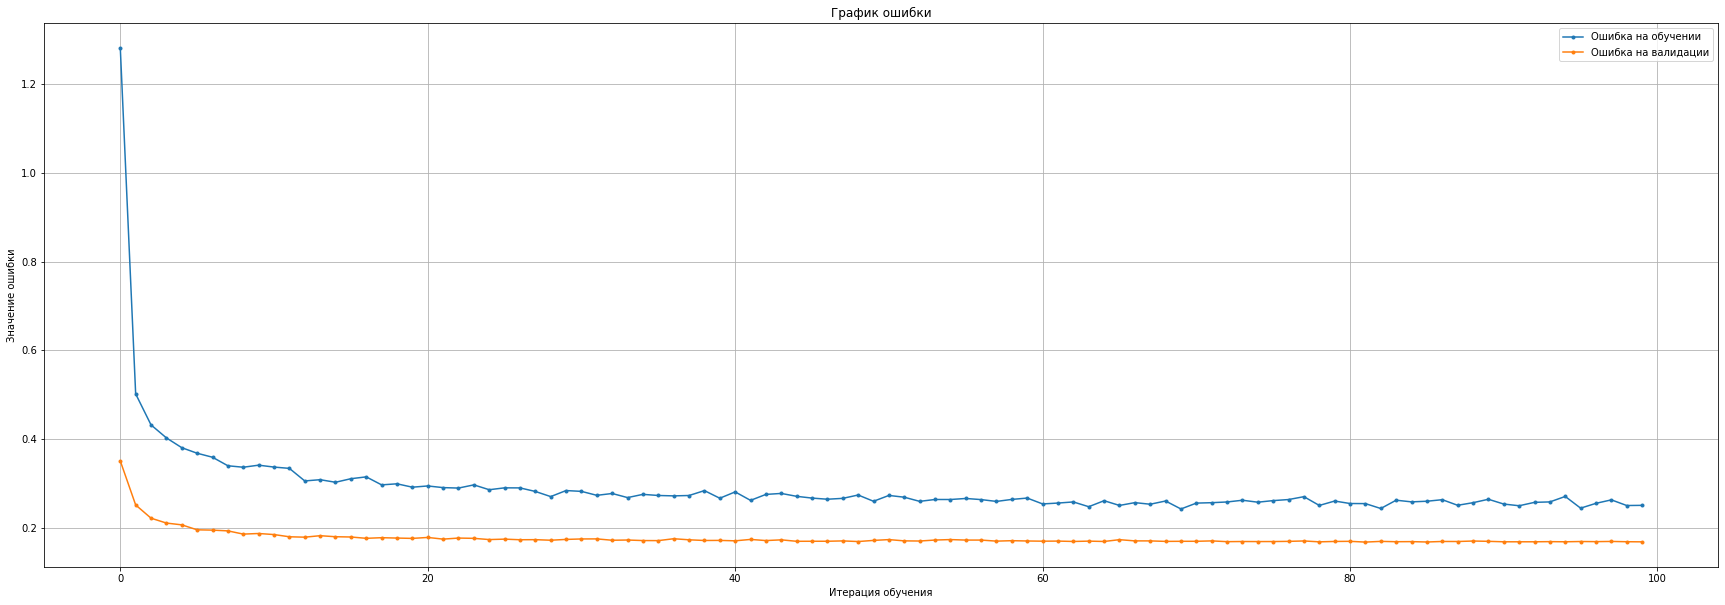

CPU times: user 8min 44s, sys: 11min 42s, total: 20min 27s
Wall time: 31min 34s


In [148]:
%%time
# Напишем цикл обучения модели
from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера или виртуальной машины
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 100
val_every = 1

# Подготовим модель
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model = model.to(dtype=x_train.dtype, device=device)

optimizer = torch.optim.SGD(
    [param for param in model.parameters() if param.requires_grad],  # только обучаемые параметры
    lr=1e-2,
    momentum=0.9,
    nesterov=True,
)

# Шедулер — отвечает за изменение шага градиентного спуска (постепенно будем уменьшать со временем)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5) 

# Не используется softmax в модели, так что нужно использовать кросс-энтропию (подаются ненормированные логиты)
loss_fn = torch.nn.CrossEntropyLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    # В одной эпохе обучения мы проходим по всем объектам из обучающей выборки — классический вариант
    local_losses = []
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        pred = model(x_batch.to(device))  # Так же переносим тензоры на устойство
        loss = loss_fn(pred, y_batch.to(device))

        loss.backward()
        optimizer.step()
        local_losses.append(loss.item())
    
    losses["train"].append(sum(local_losses) / len(local_losses))
    
    # Каждые val_every итераций считаем значение loss на валидации
    if epoch % val_every == 0:
        with torch.no_grad():
            local_losses = []
            for x_batch, y_batch in val_dataloader:
                val_pred = model(x_batch.to(device))
                val_loss = loss_fn(val_pred, y_batch.to(device))
                local_losses.append(val_loss.item())
    
            losses["val"].append(sum(local_losses) / len(local_losses))
        
    # Каждые k итераций уменьшаем шаг градиентного спуска
    if epoch % 30 == 0:
        scheduler.step()
    
    # Каждые 10 итераций рисуем графики loss-а
    if epoch % 10 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
#         plt.yscale("log")
        plt.legend()
        plt.grid()
        plt.show()

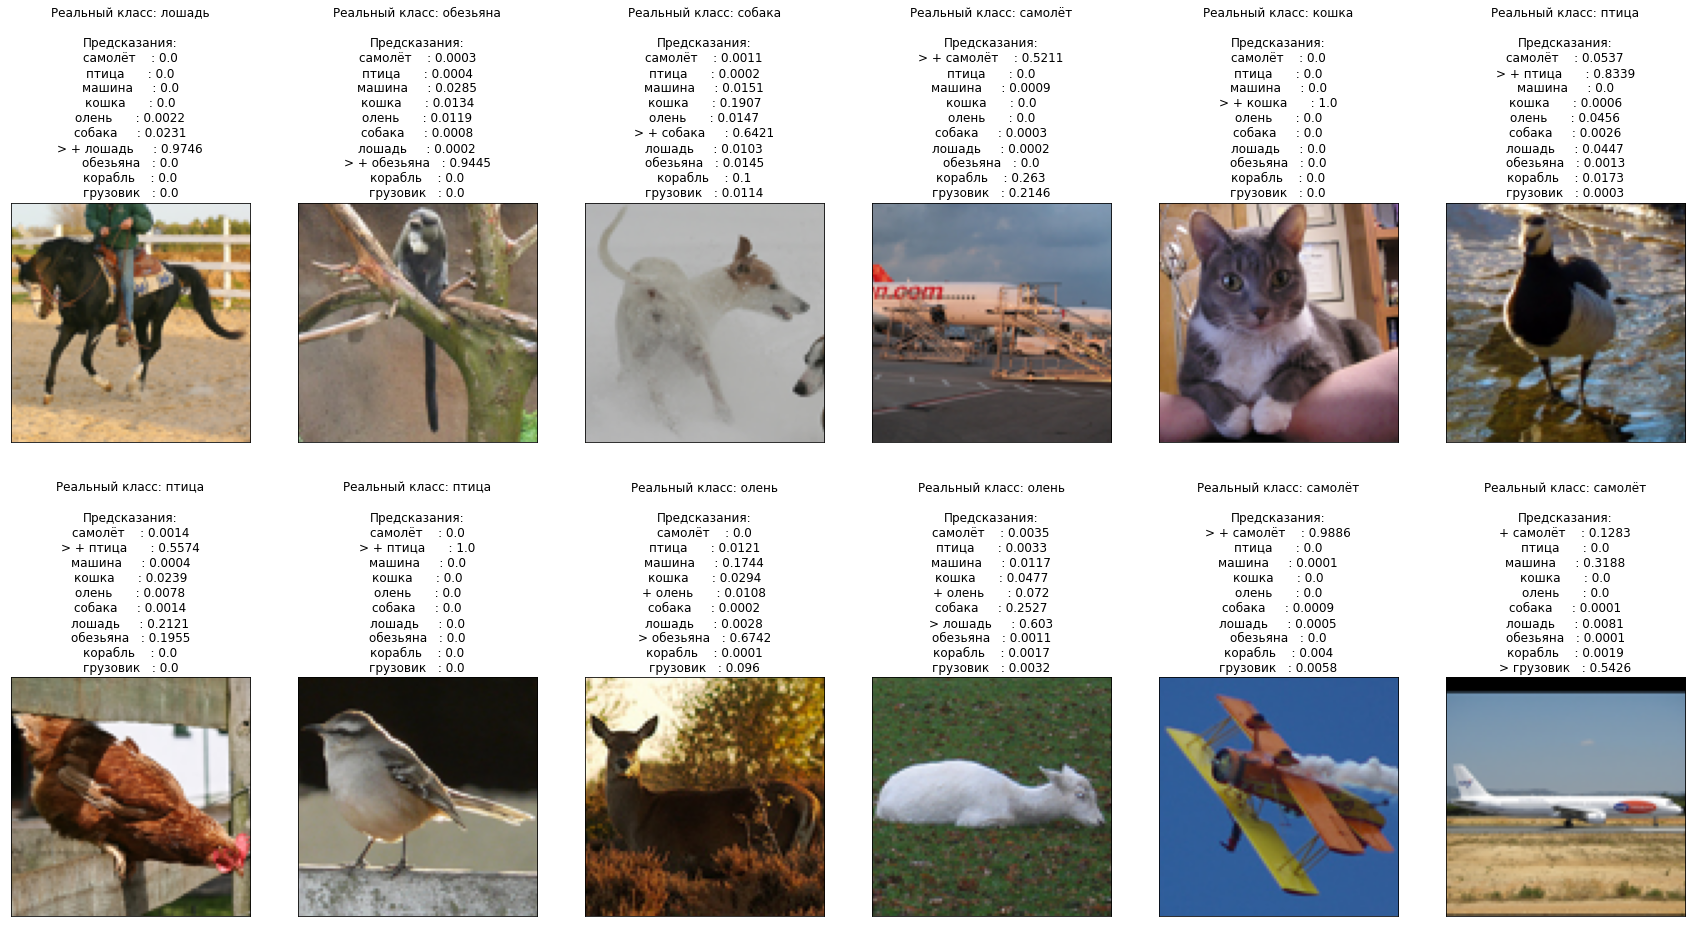

In [149]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки
def show_results(model, h=2, w=6):
    with torch.no_grad():
        batch_probs = torch.nn.functional.softmax(model(x_val[:h*w].to(device)), -1)

        fig, ax = plt.subplots(h, w, figsize=(30, 8 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i].permute(1, 2, 0))
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )
                
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)

In [150]:
# Общая доля правильных ответов на валидации
with torch.no_grad():
    accuracy = []
    for x_batch, y_batch in val_dataloader:
        preds = torch.nn.functional.softmax(model(x_batch.to(device)), -1).max(1).indices.cpu().detach()
        accuracy.extend((preds == y_batch).float().tolist())
    accuracy = sum(accuracy) / len(accuracy)
    print(accuracy)

0.94375
